In [1]:
from datasets.cifar_10 import read_data
import numpy as np
from utils import *
import matplotlib.pyplot as plt

FIG_FOLDER = 'spectral/cifar'
SAVE_PLOTS = True # save all the plots
# SAVE_PLOTS = False # save all the plots
DTYPE = np.float32

# figure size
plt.rcParams["figure.figsize"] = (10,8)

# load the data
# data are 32x32x3 images serialized
x_train, y_train = read_data.load_train_data()
x_test, y_test = read_data.load_test_data()
label_names = np.array(read_data.load_label_names())

# test = True # for testing stuff without the need to wait an eternity
test = False # for testing stuff without the need to wait an eternity
if test:
    x_train = x_train[:2000]
    y_train = y_train[:2000]
    x_test = x_test[:800]
    y_test = y_test[:800]

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train).astype(DTYPE)
x_test = scaler.transform(x_test).astype(DTYPE)

In [21]:
from sklearn.manifold import TSNE
from time import time

pp = [10, 20, 30, 40, 50, 60]
xx = []
times = []
for p in pp:
    t0 = time()
    tsne = TSNE(n_components=2, perplexity=p)
    x_train_tsne = tsne.fit_transform(x_train)
    times.append(time()-t0)
    print(f'{p}: {times[-1]:.4f} secs')
    xx.append(x_train_tsne)

10: 1188.0807 secs
20: 1185.9628 secs
30: 1356.2862 secs
40: 1910.3793 secs
50: 1815.4916 secs
60: 1877.2307 secs


In [4]:
import pandas as pd

save_folder = f'results/{FIG_FOLDER}/'
create_if_not_exists(save_folder)

# save the tsne times
col_names = ['perplexity', *pp]
data = [['seconds', *times]]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'tsne_times.xlsx', float_format="%.2f", index=False)
df.to_csv(save_folder+'tsne_times.csv', float_format="%.2f", index=False)

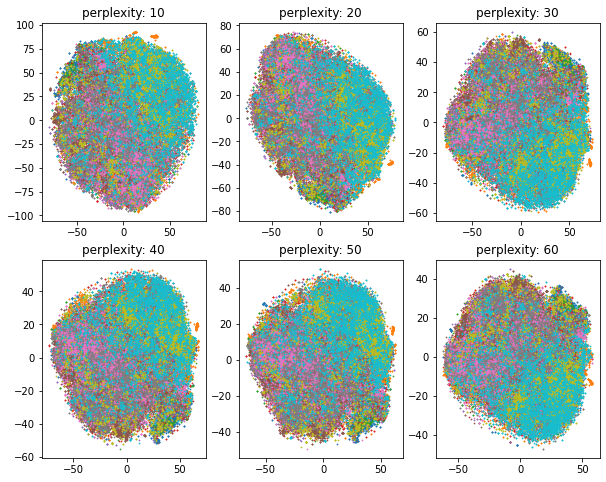

In [25]:
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12,7))
fig = plt.figure()
for n, x in enumerate(xx):
    plt.subplot(2, 3, n+1)
    for i in range(10):
        plt.scatter(x[y_train==i, 0], x[y_train==i, 1], label=f'{i}', s=.5)
    plt.title(f'perplexity: {pp[n]}')
    # plt.legend()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'tsne_all', FIG_FOLDER)

In [6]:
from sklearn.manifold import TSNE

x_train_tsne = xx.pop(5) # perplexity=60
# tsne = TSNE(n_components=2, perplexity=60)
# x_train_tsne = tsne.fit_transform(x_train)

'''
tsne = TSNE(n_components=2, perplexity=60)
x_tsne = tsne.fit_transform(np.concatenate((x_train, x_test), axis=0))
x_train_tsne = x_tsne[:x_train.shape[0],:]
x_test_tsne = x_tsne[x_train.shape[0]:,:]
'''

'\ntsne = TSNE(n_components=2, perplexity=60)\nx_tsne = tsne.fit_transform(np.concatenate((x_train, x_test), axis=0))\nx_train_tsne = x_tsne[:x_train.shape[0],:]\nx_test_tsne = x_tsne[x_train.shape[0]:,:]\n'

In [7]:
# delete xx to save memory
del xx

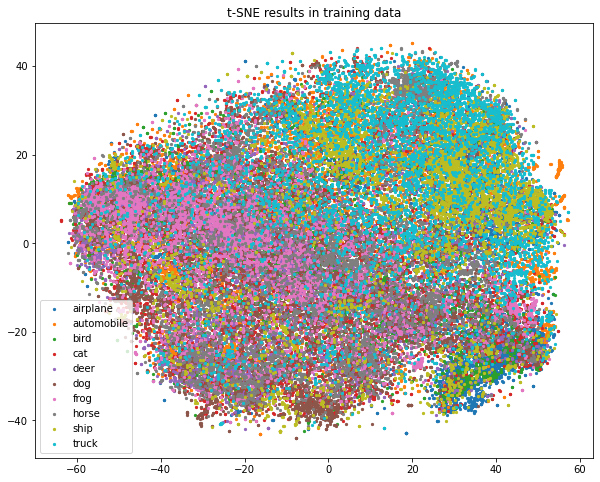

"\nfig = plt.figure()\nfor i in range(10):\n    plt.scatter(x_test_tsne[y_test==i, 0], x_test_tsne[y_test==i, 1], label=f'{i}', s=10)\nplt.title('tSNE results in test data')\nplt.legend()\nplt.show()\nif SAVE_PLOTS:\n    save_plots(fig, 'tsne_test', FIG_FOLDER)\n"

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(10):
    plt.scatter(x_train_tsne[y_train==i, 0], x_train_tsne[y_train==i, 1], label=f'{label_names[i]}', s=5)
plt.title('t-SNE results in training data')
plt.legend()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'tsne_training', FIG_FOLDER)

'''
fig = plt.figure()
for i in range(10):
    plt.scatter(x_test_tsne[y_test==i, 0], x_test_tsne[y_test==i, 1], label=f'{i}', s=10)
plt.title('tSNE results in test data')
plt.legend()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'tsne_test', FIG_FOLDER)
'''

In [9]:
from sklearn.cluster import KMeans
from spectral_embeddings import spectral_embeddings
from sklearn.metrics.cluster import adjusted_rand_score

# perform grid search
num_of_neightbors = [10, 15, 20, 25, 30, 40, 50]
num_of_embeddings = [3, 5, 8, 10, 15, 20, 30, 40]
grid_search_results = []
for n in num_of_neightbors:
    # w, v = spectral_embeddings(x_train_tsne, max(num_of_embeddings)+1, n=n, laplacian_norm=True)
    w, v = spectral_embeddings(x_train_tsne, max(num_of_embeddings)+1, n=n, laplacian_norm=False)

    res = []
    for emb in num_of_embeddings:
        pred = KMeans(n_clusters=10, random_state=69, n_init="auto").fit(v[:, 1:emb+1]).labels_
        res.append(adjusted_rand_score(y_train, pred))
    grid_search_results.append(res)

In [10]:
# save the grid search results
col_names = ['neightbors / embeddings', *num_of_embeddings]
data = [[n, *res] for n, res in zip(num_of_neightbors, grid_search_results)]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'grid_search_train.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'grid_search_train.csv', float_format="%.4f", index=False)

In [11]:
grid_search_results = np.asarray(grid_search_results)
best_n_idx, best_emb_idx = np.unravel_index(grid_search_results.argmax(), grid_search_results.shape)
print(f'neightbors: {num_of_neightbors[best_n_idx]}, embeddings: {num_of_embeddings[best_emb_idx]}')

neightbors: 15, embeddings: 20


In [12]:
from time import time

t0 = time()
# w, v = spectral_embeddings(x_train_tsne, max(num_of_embeddings)+1, n=num_of_neightbors[best_n_idx], laplacian_norm=True)
w, v = spectral_embeddings(x_train_tsne, max(num_of_embeddings)+1, n=num_of_neightbors[best_n_idx], laplacian_norm=False)
print(f'time for embeddings: {time()-t0:.4f} secs')

time for embeddings: 18.8901 secs


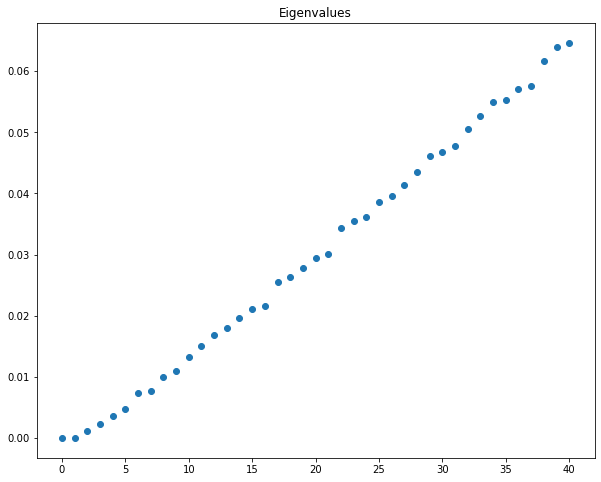

In [13]:
# plot w
fig = plt.figure()
plt.scatter(np.arange(w.shape[0], dtype=int), w)
plt.title('Eigenvalues')
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'eigenvalues', FIG_FOLDER)

In [14]:
# hold the the embeddings that we need
v = v[:, 1:num_of_embeddings[best_emb_idx]+1]

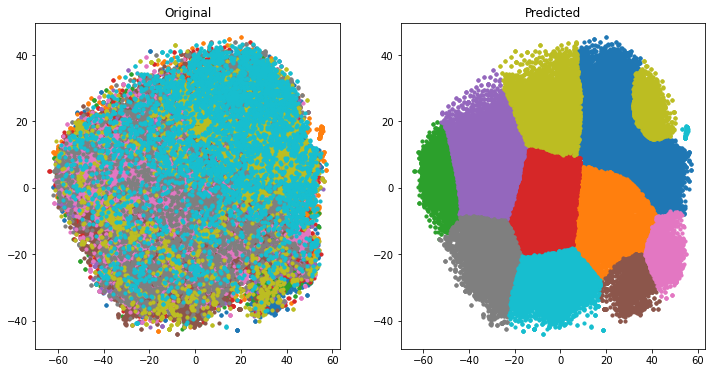

In [15]:
pred = KMeans(n_clusters=10, random_state=69, n_init="auto").fit(v).labels_
# pred = KMeans(n_clusters=10, random_state=69, n_init=10).fit(v).labels_
fig = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(x_train_tsne[y_train==i, 0], x_train_tsne[y_train==i, 1], label=f'{i}', s=10)
plt.title(f'Original')

plt.subplot(1, 2, 2)
for i in range(10):
    plt.scatter(x_train_tsne[pred==i, 0], x_train_tsne[pred==i, 1], label=f'{i}', s=10)
plt.title(f'Predicted')

plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'best_model_results', FIG_FOLDER)

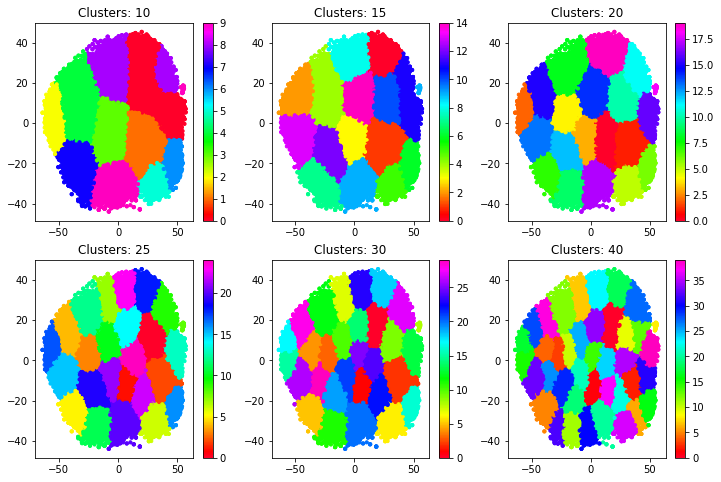

In [16]:
from sklearn.metrics import silhouette_score

# search for number of clusters > 10
n_clusters = [10, 15, 20, 25, 30, 40]
silhouette_v = []
silhouette_x = []
fig = plt.figure(figsize=(12,8))
for i, n in enumerate(n_clusters):
    pred = KMeans(n_clusters=n, random_state=69, n_init="auto").fit(v).labels_
    # pred = KMeans(n_clusters=n, random_state=69).fit(v).labels_
    silhouette_v.append(silhouette_score(v, pred, sample_size=2000))
    silhouette_x.append(silhouette_score(x_train_tsne, pred, sample_size=2000))

    plt.subplot(2, 3, i+1)
    plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=pred, s=10, cmap='gist_rainbow')
    plt.title(f'Clusters: {n}')
    plt.colorbar()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'dif_clusters', FIG_FOLDER)

In [17]:
# save the silhouette results
col_names = ['Data', *n_clusters]
data = [['Embeddings', *silhouette_v], ['TSNE 2D space', *silhouette_x]]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'silhouette_train.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'silhouette_train.csv', float_format="%.4f", index=False)